In [223]:
import uproot
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt

In [224]:
def distance_matrix(trk_x, trk_y, trk_z):
    v_matrix = np.concatenate(([trk_x], [trk_y], [trk_z]))
    gram = v_matrix.T.dot(v_matrix)

    distance = np.zeros(np.shape(gram))
    for row in range(np.shape(distance)[0]):
        for col in range(np.shape(distance)[1]): #half of the matrix is sufficient, but then mask doesn't work properly
            distance[row][col] = (gram[row][row]-2*gram[row][col]+gram[col][col])**0.5 #= 0 if row==col else 
    #print('\n'.join(['\t'.join([str("{:.2f}".format(cell)) for cell in row]) for row in distance]))
    return distance

In [225]:
def create_graph(trk_energy, trk_x, trk_y, trk_z, firstn=1):
    distance = distance_matrix(trk_x, trk_y, trk_z)
    G = nx.Graph()
    for i in range(len(trk_energy)):
        G.add_node(i, pos = (trk_x[i], trk_y[i], trk_z[i]))

        # sort indices by distance
        idx_by_distance = np.argsort(distance[i])

        # filter nodes with lower energy
        idx_above_current = filter(lambda x: trk_energy[x] > trk_energy[i], idx_by_distance)

        # add first N nodes with a higher energy
        for n, idx in enumerate(idx_above_current):
            if n == firstn:
                break
            G.add_edge(i, idx)
    return G

In [226]:
def network_plot_3D(G, color):
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111, projection='3d')
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        xi = []
        yi = []
        zi = []
        for value in pos.values():
            xi.append(value[0])
            yi.append(value[1])
            zi.append(value[2])
            
        ax.scatter(xi, yi, zi, s=30, c=color)#, cmap='rainbow', s=20+20*G.degree(key), edgecolors='k', alpha=0.7)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        for j in G.edges():
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
            # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.5)

In [227]:
def get_array(tree):
    vx     = tree['vertices_x'].array()
    vy     = tree['vertices_y'].array()
    vz     = tree['vertices_z'].array()
    energy = tree['vertices_energy'].array()
    return vx, vy, vz, energy

In [228]:
file_name = "tracksters_ds.root"
file = uproot.open(file_name)
file.classnames()

{'tracksters;1': 'TDirectory',
 'tracksters/incomplete;1': 'TTree',
 'tracksters/complete;1': 'TTree'}

In [229]:
complete_tracksters = uproot.open({file_name: 'tracksters/complete'})
incomplete_tracksters = uproot.open({file_name: 'tracksters/incomplete'})
complete_tracksters.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nvertices_x          | int32_t                  | AsDtype('>i4')
vertices_x           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_y          | int32_t                  | AsDtype('>i4')
vertices_y           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_z          | int32_t                  | AsDtype('>i4')
vertices_z           | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_energy     | int32_t                  | AsDtype('>i4')
vertices_energy      | double[]                 | AsJagged(AsDtype('>f8'))
nvertices_indexes    | int32_t                  | AsDtype('>i4')
vertices_indexes     | int64_t[]                | AsJagged(AsDtype('>i8'))


In [230]:
vx, vy, vz, energy = get_array(complete_tracksters)
in_vx, in_vy, in_vz, in_energy = get_array(incomplete_tracksters)

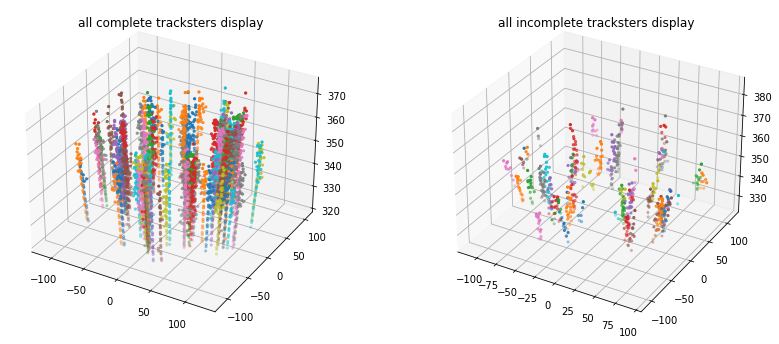

In [231]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
for x, y, z in zip(vx, vy, vz):
    ax.set_title('all complete tracksters display', x=0.5, y=1)
    ax.scatter(x, y, z, s=5)

ax = fig.add_subplot(122, projection='3d')
for x, y, z in zip(in_vx, in_vy, in_vz):
    ax.set_title('all incomplete tracksters display', x=0.5, y=1)
    ax.scatter(x, y, z, s=5)

2D and 3D plot for complete event

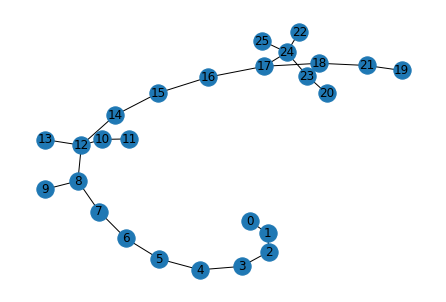

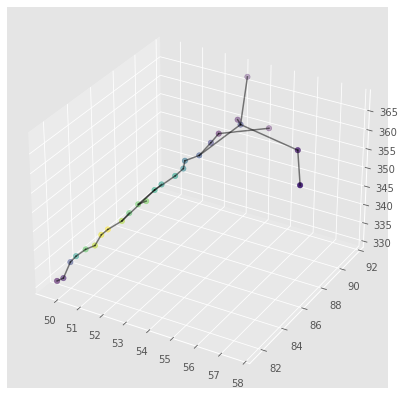

In [232]:
tid = 3
G = create_graph(energy[tid], vx[tid], vy[tid], vz[tid], firstn=1)
nx.draw(G, with_labels=True)
network_plot_3D(G, energy[tid])

2D and 3D plot for incomplete event

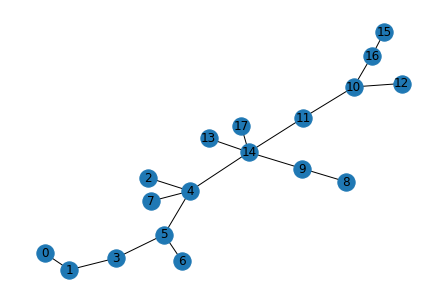

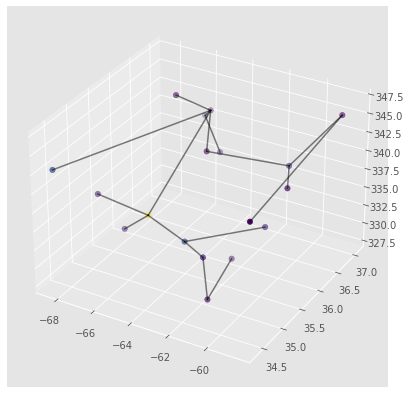

In [233]:
tid = 4
G = create_graph(in_energy[tid], in_vx[tid], in_vy[tid], in_vz[tid], firstn=1)
nx.draw(G, with_labels=True)
network_plot_3D(G, in_energy[tid])